In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.sparse import hstack
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, recall_score
from sklearn.metrics import roc_auc_score, roc_curve
import joblib

# Data load

In [214]:
data = pd.read_csv("train.csv", sep=";")
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


# Check for outliers

**We will consider only 95% records based on all of these filter criterias**

In [215]:
for column in ['balance','age','pdays','previous','duration','campaign']:
    print(column, np.percentile(data[column],list(range(95, 101, 1))))

balance [  5768.    6572.6   7777.9   9439.4  13164.9 102127. ]
age [59. 59. 60. 63. 71. 95.]
pdays [317. 337. 349. 360. 370. 871.]
previous [  3.    4.    5.    6.    8.9 275. ]
duration [ 751.   823.   914.7 1051.  1269.  4918. ]
campaign [ 8.  8. 10. 12. 16. 63.]


# Remove outliers

In [216]:
orig_rec = data.shape[0]


data = data[(data['age'] >= 18) & (data['age'] <= 60)]
data = data[data['pdays'] <= 60]
data = data[(data['campaign'] >= 0) & (data['campaign'] <= 8)]
data = data[(data['duration'] >= 0) & (data['duration'] <= 1800)]
data = data[(data['balance'] >=0) & (data['balance'] < 6000)]
new_rec = data.shape[0]


print((orig_rec - new_rec)/orig_rec*100.0, '% of data is dropped after removing outliers based on above filters')


33.59138262812147 % of data is dropped after removing outliers based on above filters


# Exploratory data analysis

**1. Ratio of term deposit made vs not made**

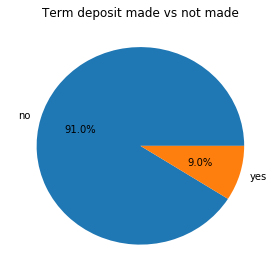

In [27]:
# Reference : https://www.pythoncharts.com/matplotlib/pie-chart-matplotlib/

fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(data['y'].value_counts(), labels=data['y'].unique(), autopct='%.1f%%')
ax.set_title('Term deposit made vs not made')
plt.tight_layout()


**Conclusion: major disbalance in the data**

# 2. Univariate Analysis

**2.1 Education wise term depositors and no depositors**

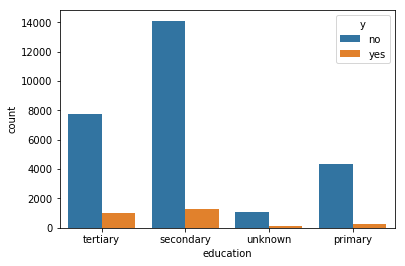

In [28]:
sns.countplot(data=data, x='education', hue='y')

**Conclusion: Mostly people have secondary level of education whether paying term desposit or not**

**2.2 Marital status wise data distribution for term depositors vs non depositors**

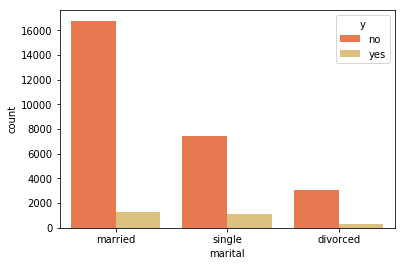

In [29]:
sns.countplot(data=data, x='marital', hue='y', palette=sns.color_palette("rainbow_r"))

**Conclusion: While majority of people have not made term deposit, out of term depositors Single people and married are major contributors.**

**2.3 Term depositors contribution marital status wise**

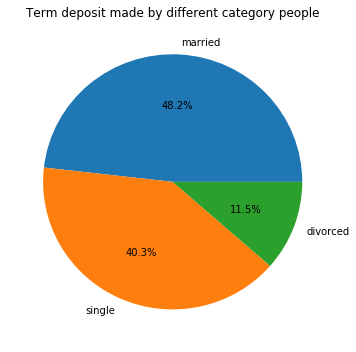

In [30]:
term_depositer = data[data['y']=='yes']['marital']

fig, ax = plt.subplots(figsize=(5, 5))
ax.pie(term_depositer.value_counts(), labels=term_depositer.value_counts().keys(), autopct='%.1f%%')
ax.set_title('Term deposit made by different category people')
plt.tight_layout()

**Conclusions: Out of people making term deposit single and married are the major contributors**

**2.4 Age distribution of term depostior vs non depositors**

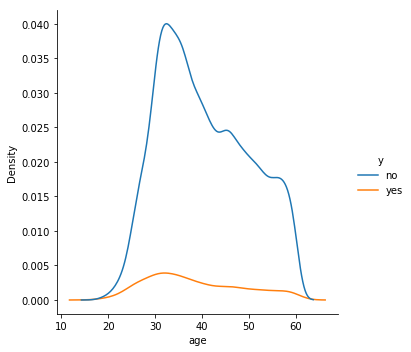

In [31]:
sns.displot(data=data, x='age', hue='y', kind='kde')

**Conclusion: Majority of term depositors are from early 30+ ages**

**2.5 For term depositors, job wise analysis**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

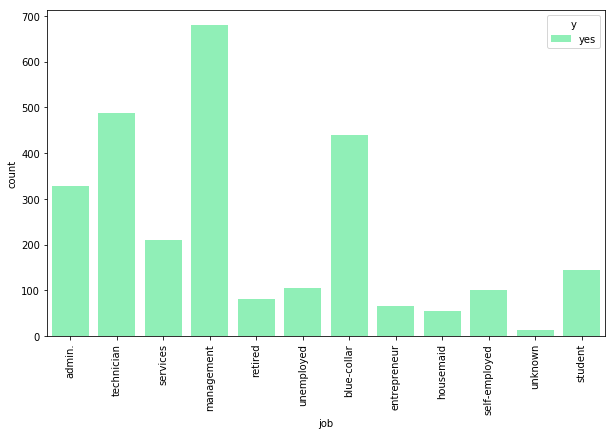

In [32]:
fig, ax= plt.subplots(figsize=(10,6))
sns.countplot(data=data[data['y']=='yes'], x='job', hue='y', ax=ax, palette='rainbow')
plt.xticks(rotation=90)


**Conclusion: Major contribtors are from Management**

**2.6 data distribution of balance for term depositor vs non term depositor**

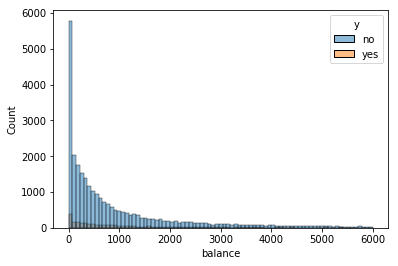

In [33]:
fig, ax = plt.subplots()

sns.histplot(data=data, x='balance', hue='y', ax=ax)

**Conclusion: for both term depositors vs non depositor we have 0 balances**

**2.7 Data ditribution for housing and loan for term and non term depositors**

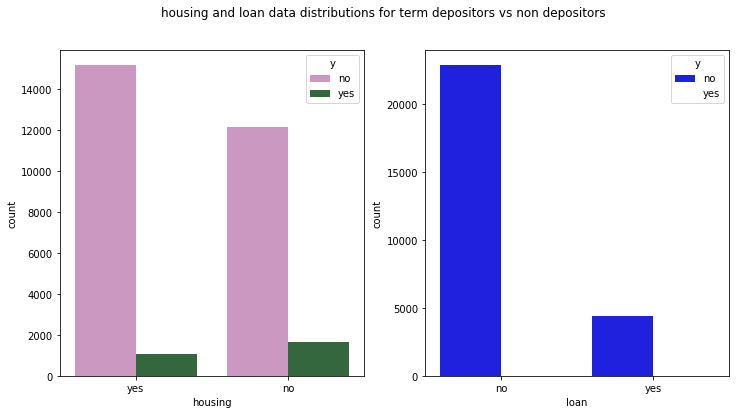

In [34]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
plt.suptitle('housing and loan data distributions for term depositors vs non depositors')
sns.countplot(data=data, x='housing', hue='y', ax=axes[0], palette='cubehelix_r')
sns.countplot(data=data, x='loan', hue='y', ax=axes[1], palette='flag_r')
plt.show()


**Conclusion: Term desposits are mostly from people who dont have any loan or housing** 

**2.8 Month wise data distribution for term and non term depositors** 

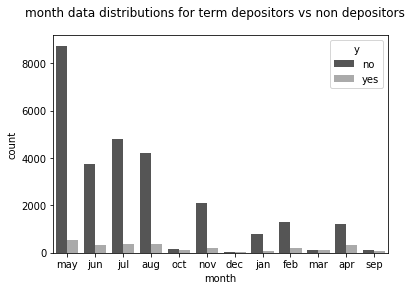

In [35]:

plt.suptitle('month data distributions for term depositors vs non depositors')
sns.countplot(data=data, x='month', hue='y', palette='binary_r')
plt.show()


**Most busy months are April, May, June, July and August**

**Conclusion: Call duration comparison for term and non tem depositors**

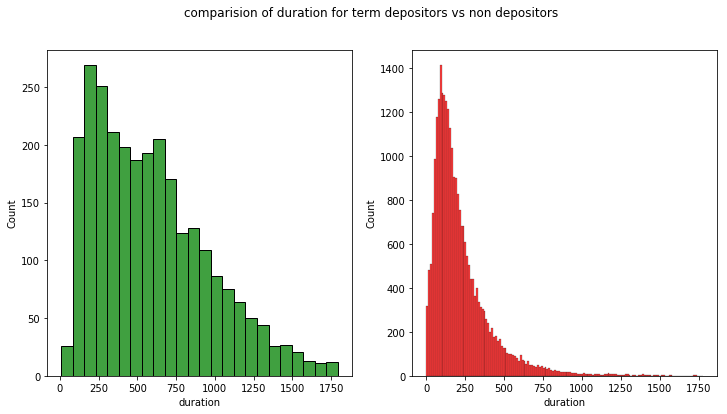

In [36]:
fig, axes = plt.subplots(1,2, figsize=(12,6))
plt.suptitle('comparision of duration for term depositors vs non depositors')
sns.histplot(data=data[data['y']=='yes'], x='duration', ax=axes[0],color='g')
sns.histplot(data=data[data['y']=='no'], x='duration', ax=axes[1], color='r')
plt.show()


**Conclusion: Term depositor calls are longer than non term depositors**

**2.10 pdays distribution of term vs non term depositors**

Text(0,0.5,'count')

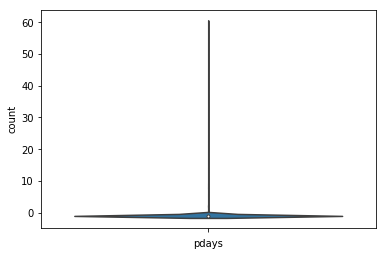

In [37]:
sns.violinplot(data=data, y='pdays', hue='y')
plt.xlabel('pdays')
plt.ylabel('count')

**Conclusion: Mostly pdays are -1 which means customers were not called, however to save some data we have considered pdays<=60**

# 3. BI VARIATE analysis

**3.1 jobs and balances**

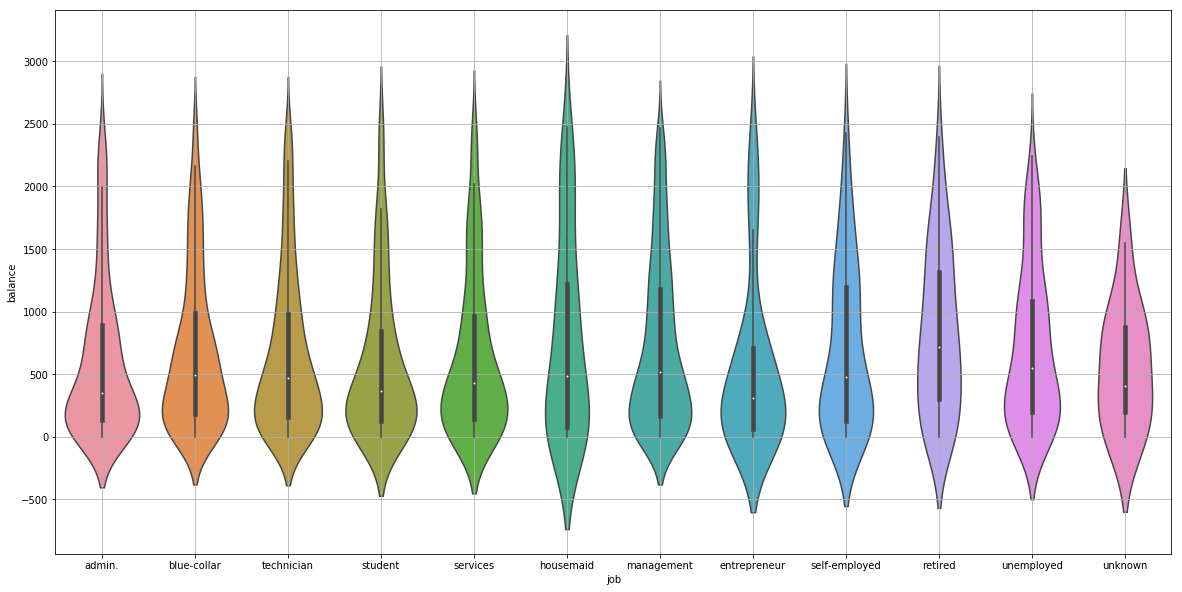

In [41]:
plt.figure(figsize=(20,10))
sns.violinplot(data=data2[data2['y']=='yes'].sort_values(by='balance', ascending=False), x='job', y='balance')
plt.grid()

**Conclusion: management and retired class of people tend to have higher balances may be due to higher salary or post retirement savings**

**3.2 Education and balance together analysis**

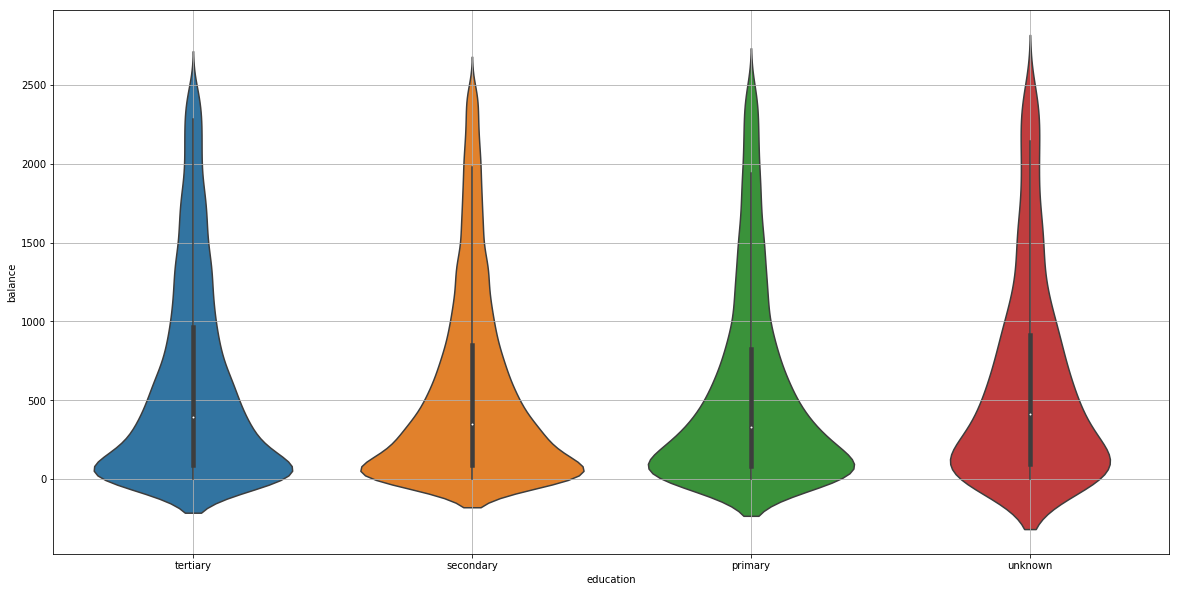

In [42]:
plt.figure(figsize=(20,10))
sns.violinplot(data=data2.sort_values(by='balance', ascending=False), x='education', y='balance')
plt.grid()

**Conclusion: people with tertiary class of education, seems that have more balance -- may be due to higher income.
Also more people are there with secondary and primary education due to large bandwidth that the graphs are showing.**


**3.3 analysis of the balance vs jobs for people with liabilities**

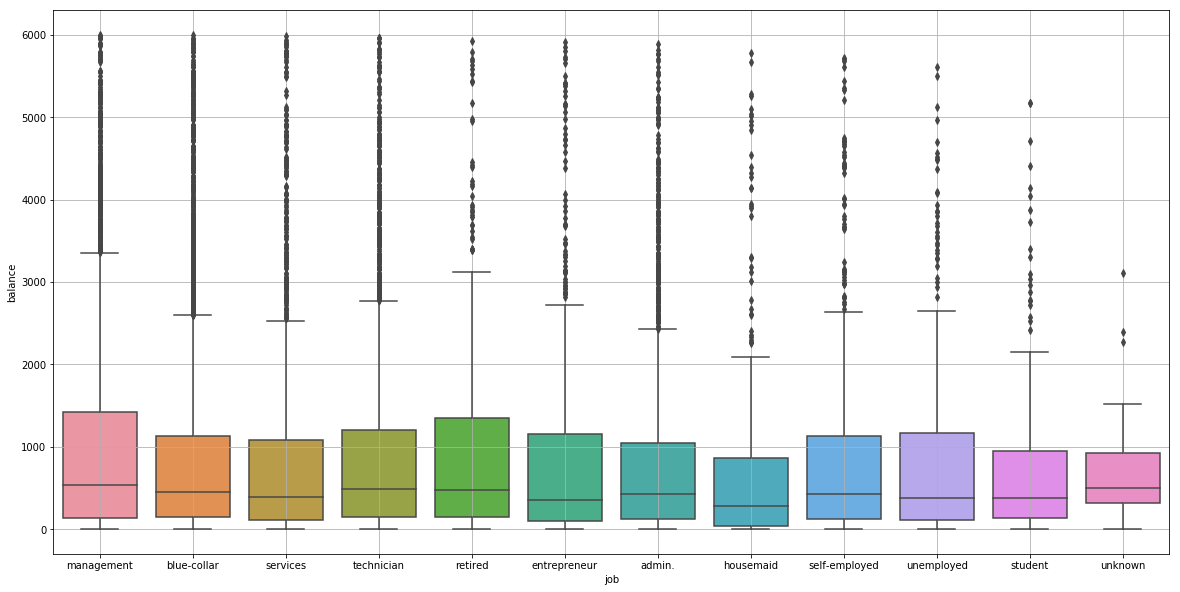

In [43]:
plt.figure(figsize=(20,10))
sns.boxplot(data=data[(data['y']=='yes')  & (data['default']=='yes') | (data['housing']=='yes') | (data['loan']=='yes') ].sort_values(by='balance', ascending=False), x='job', y='balance')
plt.grid()

**Conclusion: Average balance of retired and management customers who opted for term deposit are on the higher side even after having some or other liabilties**

**3.4 balance and term deposit relation**

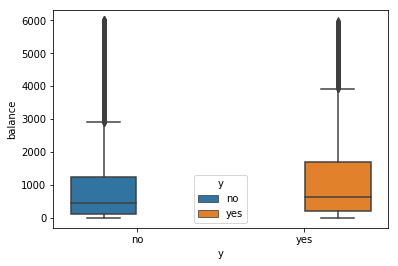

In [44]:
sns.boxplot(data = data, x='y', y='balance', hue='y')

**Conclusion: Higher balance for term depositors**

**3.5 call duration for term depositor vs non depositors**

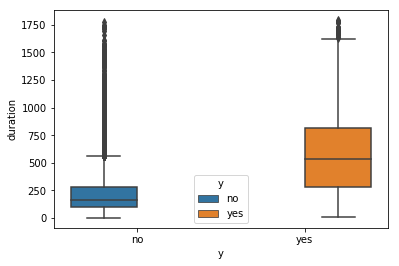

In [45]:
sns.boxplot(data = data, x='y', y='duration', hue='y')

**Conclusion: Call duration for term depositor is higher usually**

**all numerical variable correlation with y**

In [217]:
data['y'] = data['y'].map({'yes':1, 'no':0}) 

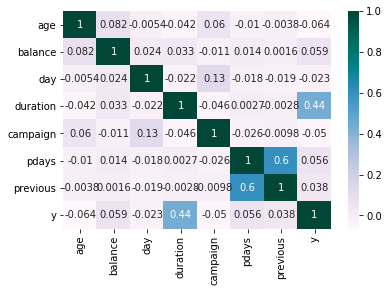

In [58]:
sns.heatmap(data.corr(), annot=True, cmap='PuBuGn')

**y is strongly postively related with duration of the call made to attract customers**

In [70]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


# DATA Preprocessing

In [48]:
# 0) column dropping
# 1) train test split 
# 2) data type conversion numeric columns 
# 3) duration to minutes 
# 4) class label 0 and 1 mapping 
# 5) numeric data standardization 
# 6) feature correlation numeric data 
# 7) label encoding / one hot encoding for categorical features 

**map labels to 0 and 1 and Drop columns**

In [218]:
labels = data['y']   #.map({'yes':1, 'no':0}) 
data.drop(['day','previous', 'y'], axis=1, inplace=True)

**update the datatype**

In [219]:
data['age'] = data.age.astype('float64')
data['balance'] = data.balance.astype('float64')
data['campaign'] = data.campaign.astype('float64')
data['pdays'] = data.pdays.astype('float64')
data['duration'] = data.duration.astype('float64')/60.0


**train test split**

In [220]:
trainx, testx, trainy, testy = train_test_split(data, labels, test_size=0.3, stratify=labels)

In [8]:
trainx.shape, testx.shape

((21016, 14), (9008, 14))

**column standardization and one hot enoding and label encoding**

In [221]:
sd_age = StandardScaler()
sd_balance = StandardScaler()
sd_duration = StandardScaler()
sd_campaign = StandardScaler()
sd_pdays = StandardScaler()
average_calls_current_campaign_sd = StandardScaler()

le_housing_loan = LabelEncoder()
le_housing_default = LabelEncoder()
le_loan_default = LabelEncoder()
le_housing_loan_default = LabelEncoder()

le_job = LabelEncoder()
le_education = LabelEncoder()
ohe_marital = OneHotEncoder()
ohe_default = OneHotEncoder()
ohe_housing = OneHotEncoder()
ohe_loan = OneHotEncoder()
ohe_contact = OneHotEncoder()
ohe_poutcome = OneHotEncoder()
ohe_month = OneHotEncoder()

##########################TRAIN DATA#################################

trainx_age_sd = sd_age.fit_transform(trainx['age'].values.reshape(-1,1))
trainx_balance_sd = sd_balance.fit_transform(trainx['balance'].values.reshape(-1,1))
trainx_duration_sd = sd_duration.fit_transform(trainx['duration'].values.reshape(-1,1))
trainx_campaign_sd = sd_campaign.fit_transform(trainx['campaign'].values.reshape(-1,1))
trainx_pdays_sd = sd_pdays.fit_transform(trainx['pdays'].values.reshape(-1,1))  # wherever negative replace with -1

trainx_pdays_sd = np.where(trainx_pdays_sd<0,-1,trainx_pdays_sd)

trainx_job_le = le_job.fit_transform(trainx['job']).reshape(-1,1)
trainx_education_le = le_education.fit_transform(trainx['education']).reshape(-1,1)
trainx_marital_ohe = ohe_marital.fit_transform(trainx['marital'].values.reshape(-1,1))
trainx_default_ohe = ohe_default.fit_transform(trainx['default'].values.reshape(-1,1))
trainx_housing_ohe = ohe_housing.fit_transform(trainx['housing'].values.reshape(-1,1))
trainx_loan_ohe = ohe_loan.fit_transform(trainx['loan'].values.reshape(-1,1))
trainx_contact_ohe = ohe_contact.fit_transform(trainx['contact'].values.reshape(-1,1))
trainx_month_ohe = ohe_month.fit_transform(trainx['month'].values.reshape(-1,1))
trainx_poutcome_ohe = ohe_poutcome.fit_transform(trainx['poutcome'].values.reshape(-1,1))





##########################TEST DATA#################################

testx_age_sd = sd_age.transform(testx['age'].values.reshape(-1,1))
testx_balance_sd = sd_balance.transform(testx['balance'].values.reshape(-1,1))
testx_duration_sd = sd_duration.transform(testx['duration'].values.reshape(-1,1))
testx_campaign_sd = sd_campaign.transform(testx['campaign'].values.reshape(-1,1))
testx_pdays_sd = sd_pdays.transform(testx['pdays'].values.reshape(-1,1))  # wherever negative replace with -1

testx_pdays_sd = np.where(testx_pdays_sd<0,-1,testx_pdays_sd)

testx_job_le = le_job.transform(testx['job']).reshape(-1,1)
testx_education_le = le_education.transform(testx['education']).reshape(-1,1)
testx_marital_ohe = ohe_marital.transform(testx['marital'].values.reshape(-1,1))
testx_default_ohe = ohe_default.transform(testx['default'].values.reshape(-1,1))
testx_housing_ohe = ohe_housing.transform(testx['housing'].values.reshape(-1,1))
testx_loan_ohe = ohe_loan.transform(testx['loan'].values.reshape(-1,1))
testx_contact_ohe = ohe_contact.transform(testx['contact'].values.reshape(-1,1))
testx_month_ohe = ohe_month.transform(testx['month'].values.reshape(-1,1))
testx_poutcome_ohe = ohe_poutcome.transform(testx['poutcome'].values.reshape(-1,1))

In [ ]:
## COMBINE DATA ###

In [222]:
trainx_all = hstack((trainx_age_sd, trainx_job_le, trainx_marital_ohe, trainx_education_le, trainx_default_ohe, trainx_balance_sd, trainx_loan_ohe, trainx_housing_ohe,  trainx_contact_ohe, trainx_month_ohe, trainx_campaign_sd, trainx_pdays_sd, trainx_poutcome_ohe))
testx_all = hstack((testx_age_sd, testx_job_le, testx_marital_ohe, testx_education_le, testx_default_ohe, testx_balance_sd, testx_loan_ohe, testx_housing_ohe, testx_contact_ohe, testx_month_ohe, testx_campaign_sd, testx_pdays_sd, testx_poutcome_ohe))

# Utility functions

In [11]:
def plot_parameter_vs_metric(grid_model, n):
    '''
    pass grid model and number of maximum parameters to plot the results
    '''
    train_roc_scores = grid_model.cv_results_['mean_train_score']
    test_roc_scores = grid_model.cv_results_['mean_test_score']
    n_neighbors = list(range(1,n,2))

    plt.plot(n_neighbors, train_roc_scores,label='train')
    plt.plot(n_neighbors, test_roc_scores,label='train')
    plt.grid()
    plt.legend()
    plt.title('roc scores vs parameter for train and test datasets')
    plt.xlabel('parameters')
    plt.ylabel('roc auc scores')

    
def plot_roc_auc_curve(trainy, trainy_pred_prob, testy, testy_pred_prob): 
    '''
    plot roc auc curve given train and test datasets.
    '''
    train_fprs, train_tprs, train_thresholds = roc_curve(trainy, trainy_pred_prob[:,1])
    test_fprs, test_tprs, test_thresholds = roc_curve(testy, testy_pred_prob[:,1])

    plt.plot(train_fprs, train_tprs, label='Train')
    plt.plot(test_fprs, test_tprs, label='Test')
    plt.plot([0,1])
    plt.legend()
    plt.grid()    
    
    
def threshold_based_predict(probability_scores,fpr,tpr,thresholds):
    predictions=[]
    cutoff=thresholds[np.argmin(np.sqrt(np.square(1-tpr) + np.square(fpr)))]

    for p in probability_scores:
        if p>=cutoff:
            predictions.append(1)
        else:
            predictions.append(0)
    print('optimal theshold',cutoff)
    return predictions 


def plot_confusion_matrix(test_y,test_y_pred, dataset_type):
    '''
     This function takes test class labels and predicted class labels and plots
     confusion matrix.
    '''
    cm=confusion_matrix(test_y,test_y_pred)
    label=pd.DataFrame(cm)
    label.iloc[0,0]='TN={}'.format(label.iloc[0,0])
    label.iloc[0,1]='FN={}'.format(label.iloc[0,1])
    label.iloc[1,0]='FP={}'.format(label.iloc[1,0])
    label.iloc[1,1]='TP={}'.format(label.iloc[1,1])
    
    plt.close()
    plt.figure(figsize=(6,4)) 
    sns.heatmap(cm,xticklabels=['Negative','Positive'],yticklabels=['Negative','Positive'], cmap='Dark2',annot=label,linewidths=1,linecolor='black',fmt='s')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Confusion Matrix for the ' + dataset_type + ' data')
    plt.show()
    

# Model Building


# KNN Classifier

In [14]:
# Hyper parameter tunned KNN

knn_params_grid={'n_neighbors':list(range(1,30,2))}
knn = KNeighborsClassifier(algorithm='auto',weights='distance')
knn_grid = GridSearchCV(estimator=knn, param_grid=knn_params_grid, scoring='roc_auc')
knn_grid.fit(trainx_all, trainy)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


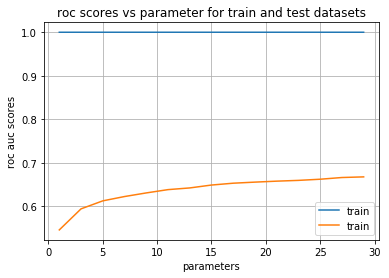

In [17]:
plot_parameter_vs_metric(knn_grid, 30)

In [18]:
knn_grid.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=29, p=2,
           weights='distance')

**Train best estimator with the data point** 

In [31]:
best_knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=29, p=2,
           weights='distance')

best_knn.fit(trainx_all, trainy)
trainy_pred_prob = best_knn.predict_proba(trainx_all)
testy_pred_prob = best_knn.predict_proba(testx_all)

print('Train roc score', round(roc_auc_score(trainy, trainy_pred_prob[:,1]),3), 'Test roc score', round(roc_auc_score(testy, testy_pred_prob[:,1]),3))

# plot_roc_auc_curve(trainy, trainy_pred_prob,testy, testy_pred_prob)      

Train roc score 1.0 Test roc score 0.674


**predicting the labels based on threshold**

In [32]:
train_fprs, train_tprs, train_thresholds = roc_curve(trainy, trainy_pred_prob[:,1])
test_fprs, test_tprs, test_thresholds = roc_curve(testy, testy_pred_prob[:,1])

trainy_pred = threshold_based_predict(trainy_pred_prob[:,1],train_fprs,train_tprs,train_thresholds)
testy_pred = threshold_based_predict(testy_pred_prob[:,1],test_fprs,test_tprs,test_thresholds)

optimal theshold 0.3333333333333333
optimal theshold 0.08077033001868775


**roc auc curve**

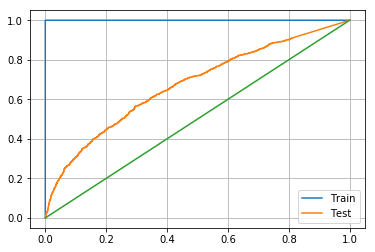

In [33]:
plot_roc_auc_curve(trainy, trainy_pred_prob, testy, testy_pred_prob)

**pretty bad** 

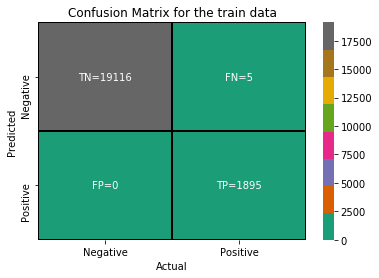

In [34]:
plot_confusion_matrix(trainy, trainy_pred, 'train')

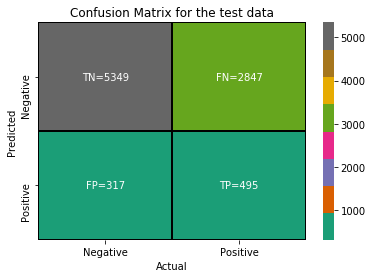

In [35]:
plot_confusion_matrix(testy, testy_pred, 'test')

**KNN does not seem to work well since for the train data, FN and FP are very less but for test data they are high
which means KNN is not able to generalize well**

# Logistic Regression

In [36]:
# Hyper parameter tunned LR

lr_params_grid={'C':[10**x for x in range(-5,6)]}
lr = LogisticRegression(class_weight='balanced')
lr_grid = GridSearchCV(estimator=lr, param_grid=lr_params_grid, scoring='roc_auc')
lr_grid.fit(trainx_all, trainy)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\rap\appd

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Train roc score 0.725 Test roc score 0.731


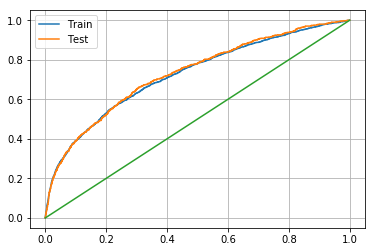

In [37]:
best_lr = lr_grid.best_estimator_
best_lr.fit(trainx_all, trainy)
trainy_pred_prob = best_lr.predict_proba(trainx_all)
testy_pred_prob = best_lr.predict_proba(testx_all)

print('Train roc score', round(roc_auc_score(trainy, trainy_pred_prob[:,1]),3), 'Test roc score', round(roc_auc_score(testy, testy_pred_prob[:,1]),3))

plot_roc_auc_curve(trainy, trainy_pred_prob,testy, testy_pred_prob)      

In [156]:
train_fprs, train_tprs, train_thresholds = roc_curve(trainy, trainy_pred_prob[:,1])
test_fprs, test_tprs, test_thresholds = roc_curve(testy, testy_pred_prob[:,1])

trainy_pred = threshold_based_predict(trainy_pred_prob[:,1],train_fprs,train_tprs,train_thresholds)
testy_pred = threshold_based_predict(testy_pred_prob[:,1],test_fprs,test_tprs,test_thresholds)

optimal theshold 0.4902029384776264
optimal theshold 0.9999999999982974


In [38]:
trainy_pred = np.argmax(trainy_pred_prob[:], axis=1)
testy_pred = np.argmax(testy_pred_prob[:], axis=1)

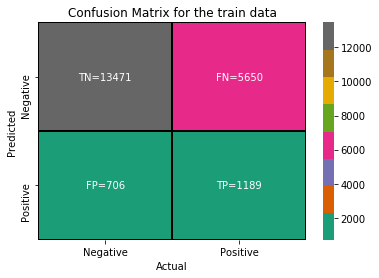

In [39]:
plot_confusion_matrix(trainy, trainy_pred, 'train')

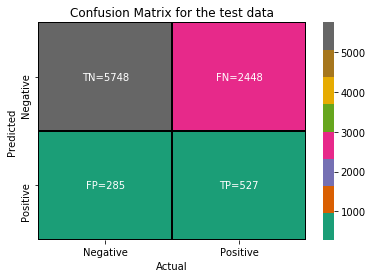

In [40]:
plot_confusion_matrix(testy, testy_pred, 'test')

**LR model is somewhat better since there is less overfitting more roc auc score but still not great since there are many misclassifications, confusion matrix says 
people who are term depositors are misclassified as not**

# RBF Kernel SVM

In [41]:
# Hyper parameter tunned SVM

svm_params_grid={'C':[10**x for x in range(-3,4)], 'gamma':[10**x for x in range(-4,2)]}
svm = SVC(class_weight='balanced')
svm_grid = GridSearchCV(estimator=svm, param_grid=svm_params_grid, scoring='roc_auc')
svm_grid.fit(trainx_all, trainy)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [42]:
svm_grid.best_estimator_

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [18]:
#  = svm_grid.best_estimator_
best_svm = SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
best_svm.fit(trainx_all, trainy)
clf = CalibratedClassifierCV(best_svm)
clf.fit(trainx_all, trainy)
trainy_pred_prob = clf.predict_proba(trainx_all)
testy_pred_prob = clf.predict_proba(testx_all)


print('Train roc score', round(roc_auc_score(trainy, trainy_pred_prob[:,1]),3), 'Test roc score', round(roc_auc_score(testy, testy_pred_prob[:,1]),3))


Train roc score 0.753 Test roc score 0.725


In [13]:
train_fprs, train_tprs, train_thresholds = roc_curve(trainy, trainy_pred_prob[:,1])
test_fprs, test_tprs, test_thresholds = roc_curve(testy, testy_pred_prob[:,1])

trainy_pred = threshold_based_predict(trainy_pred_prob[:,1],train_fprs,train_tprs,train_thresholds)
testy_pred = threshold_based_predict(testy_pred_prob[:,1],test_fprs,test_tprs,test_thresholds)

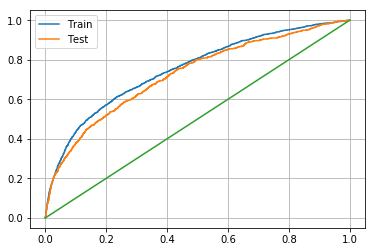

In [40]:
plot_roc_auc_curve(trainy, trainy_pred_prob,testy, testy_pred_prob)  

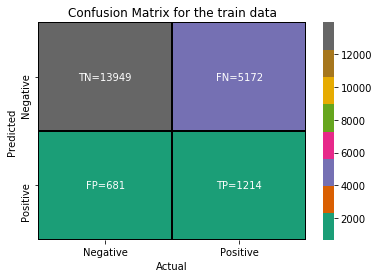

In [46]:
plot_confusion_matrix(trainy, trainy_pred, 'train')

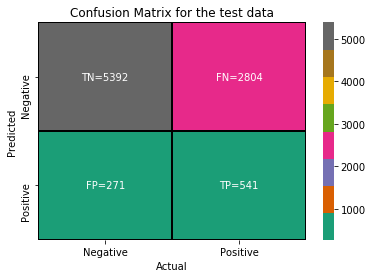

In [45]:
plot_confusion_matrix(testy, testy_pred, 'test')

**RBF Kernel SVM is doing good job with decent score of .725 test roc auc score**

# Linear SVM

In [48]:
# Hyper parameter tunned LR

lsvm_params_grid={'alpha':[10**x for x in range(-5,6)]}
lsvm = SGDClassifier(loss='hinge', class_weight='balanced')
lsvm_grid = GridSearchCV(estimator=lsvm, param_grid=lsvm_params_grid, scoring='roc_auc')
lsvm_grid.fit(trainx_all, trainy)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDCla

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [49]:
lsvm_grid.best_estimator_

SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

**Training with best kernel**

In [51]:
best_lsvm = SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

best_lsvm.fit(trainx_all, trainy)
clf = CalibratedClassifierCV(best_lsvm)
clf.fit(trainx_all, trainy)
trainy_pred_prob = clf.predict_proba(trainx_all)
testy_pred_prob = clf.predict_proba(testx_all)


print('Train roc score', round(roc_auc_score(trainy, trainy_pred_prob[:,1]),3), 'Test roc score', round(roc_auc_score(testy, testy_pred_prob[:,1]),3))

# plot_roc_auc_curve(trainy, trainy_pred_prob,testy, testy_pred_prob)    

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter

Train roc score 0.711 Test roc score 0.713


c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


In [52]:
train_fprs, train_tprs, train_thresholds = roc_curve(trainy, trainy_pred_prob[:,1])
test_fprs, test_tprs, test_thresholds = roc_curve(testy, testy_pred_prob[:,1])

trainy_pred = threshold_based_predict(trainy_pred_prob[:,1],train_fprs,train_tprs,train_thresholds)
testy_pred = threshold_based_predict(testy_pred_prob[:,1],test_fprs,test_tprs,test_thresholds)

optimal theshold 0.09310075354053964
optimal theshold 0.09331596916555489


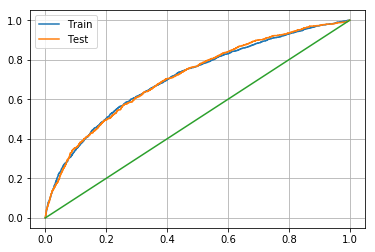

In [53]:
plot_roc_auc_curve(trainy, trainy_pred_prob,testy, testy_pred_prob)  

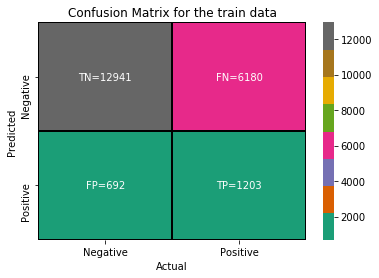

In [55]:
plot_confusion_matrix(trainy, trainy_pred, 'train')

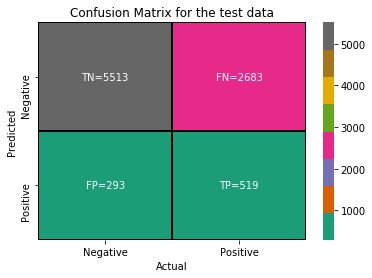

In [56]:
plot_confusion_matrix(testy, testy_pred, 'test')

**RBF Kernel is better than linear kernel**

In [ ]:
# Ideal most case: FN and TN should be high 
# Real case: FN (actually customer wanted to make deposit but model said he wont and hence bank should not call them !!!! Dangerous !!!)
#            FP (actually customer will not deposit but model said he will This certainly can be some small value but not high ) For
#             these few cases, bank can call and confirm 

# linear SVM is worst since it is misguiding model. 

# XgBoost

In [57]:
xgb_params_grid={'scale_pos_weight': [7,9,11,13], 'learning_rate':[0.2,0.1,0.15], 'n_estimators':[20,50,100,200], 'subsample':[0.7,0.8,0.9], 'colsample_bytree':[0.7,0.8,0.9]}
xgb = XGBClassifier()
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params_grid, scoring='roc_auc')
xgb_grid.fit(trainx_all, trainy)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'scale_pos_weight': [7, 9, 11, 13], 'learning_rate': [0.2, 0.1, 0.15], 'n_estimators': [20, 50, 100, 200], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [58]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=None,
       silent=True, subsample=0.9)

In [59]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=None,
       silent=True, subsample=0.9)
xgb.fit(trainx_all, trainy)
clf = CalibratedClassifierCV(xgb)
clf.fit(trainx_all, trainy)
trainy_pred_prob = clf.predict_proba(trainx_all)
testy_pred_prob = clf.predict_proba(testx_all)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [60]:
train_fprs, train_tprs, train_thresholds = roc_curve(trainy, trainy_pred_prob[:,1])
test_fprs, test_tprs, test_thresholds = roc_curve(testy, testy_pred_prob[:,1])

trainy_pred = threshold_based_predict(trainy_pred_prob[:,1],train_fprs,train_tprs,train_thresholds)
testy_pred = threshold_based_predict(testy_pred_prob[:,1],test_fprs,test_tprs,test_thresholds)

optimal theshold 0.08364427586396535
optimal theshold 0.08436698963244756


In [62]:
print('Train roc score', round(roc_auc_score(trainy, trainy_pred_prob[:,1]),3), 'Test roc score', round(roc_auc_score(testy, testy_pred_prob[:,1]),3))

Train roc score 0.755 Test roc score 0.733


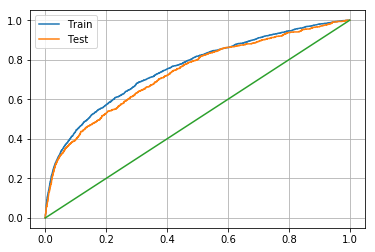

In [61]:
plot_roc_auc_curve(trainy, trainy_pred_prob,testy, testy_pred_prob)  

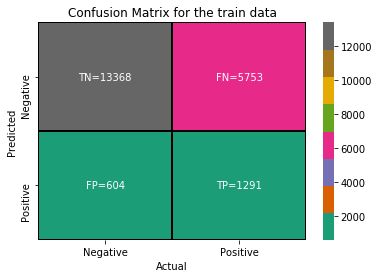

In [65]:
plot_confusion_matrix(trainy, trainy_pred, 'train')

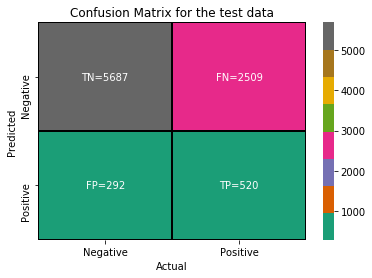

In [64]:
plot_confusion_matrix(testy, testy_pred, 'test')

**Certainly improved score with less overfitting as compared to other models**

**Feature Engineering**

In [223]:
# trainx.loc[:, 'housing and loan'] = trainx[(trainx['loan']=='yes') & (trainx['housing']=='yes')]

trainx.loc[:,'housing_loan']=(trainx['housing']=='yes') & (trainx['loan']=='yes')
trainx.loc[:, 'housing_default']=(trainx['housing']=='yes') & (trainx['default']=='yes')
trainx.loc[:, 'loan_default']=(trainx['loan']=='yes') & (trainx['default']=='yes')
trainx.loc[:, 'housing_loan_default']=(trainx['housing']=='yes') & (trainx['loan']=='yes') & (trainx['default']=='yes')
trainx.loc[:,'average_calls_current_campaign'] = trainx['duration']/trainx['campaign']


# testx.loc[:, 'housing and loan'] = testx[(testx['loan']=='yes') & (testx['housing']=='yes')]

testx.loc[:,'housing_loan']=(testx['housing']=='yes') & (testx['loan']=='yes')
testx.loc[:, 'housing_default']=(testx['housing']=='yes') & (testx['default']=='yes')
testx.loc[:, 'loan_default']=(testx['loan']=='yes') & (testx['default']=='yes')
testx.loc[:, 'housing_loan_default']=(testx['housing']=='yes') & (testx['loan']=='yes') & (testx['default']=='yes')
testx.loc[:,'average_calls_current_campaign'] = testx['duration']/testx['campaign']

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [224]:
le_housing_loan = LabelEncoder()
le_housing_default = LabelEncoder()
le_loan_default = LabelEncoder()
le_housing_loan_default = LabelEncoder()


######TRAIN#######
trainx_housing_loan_le = le_housing_loan.fit_transform(trainx['housing_loan']).reshape(-1,1)
trainx_housing_default_le = le_housing_default.fit_transform(trainx['housing_default']).reshape(-1,1)
trainx_loan_default_le = le_loan_default.fit_transform(trainx['loan_default']).reshape(-1,1)
trainx_housing_loan_default_le = le_housing_loan_default.fit_transform(trainx['housing_loan_default']).reshape(-1,1)
trainx_average_calls_current_campaign_sd = average_calls_current_campaign_sd.fit_transform(trainx['average_calls_current_campaign'].values.reshape(-1,1))


######TEST#######
testx_housing_loan_le = le_housing_loan.transform(testx['housing_loan']).reshape(-1,1)
testx_housing_default_le = le_housing_default.transform(testx['housing_default']).reshape(-1,1)
testx_loan_default_le = le_loan_default.transform(testx['loan_default']).reshape(-1,1)
testx_housing_loan_default_le = le_housing_loan_default.transform(testx['housing_loan_default']).reshape(-1,1)
testx_average_calls_current_campaign_sd = average_calls_current_campaign_sd.transform(testx['average_calls_current_campaign'].values.reshape(-1,1))



In [225]:
trainx_all = hstack((trainx_age_sd, trainx_job_le, trainx_marital_ohe, trainx_education_le, trainx_default_ohe, trainx_balance_sd, trainx_loan_ohe, trainx_housing_ohe, trainx_contact_ohe, trainx_month_ohe, trainx_duration_sd, trainx_campaign_sd, trainx_pdays_sd, trainx_poutcome_ohe, trainx_average_calls_current_campaign_sd, trainx_housing_loan_le,trainx_housing_default_le, trainx_loan_default_le, trainx_housing_loan_default_le))
testx_all = hstack((testx_age_sd, testx_job_le, testx_marital_ohe, testx_education_le, testx_default_ohe, testx_balance_sd, testx_loan_ohe,  testx_housing_ohe, testx_contact_ohe, testx_month_ohe, testx_duration_sd, testx_campaign_sd, testx_pdays_sd, testx_poutcome_ohe, testx_average_calls_current_campaign_sd, testx_housing_loan_le,testx_housing_default_le, testx_loan_default_le, testx_housing_loan_default_le))

# XGBoost with added features

In [71]:
xgb_params_grid={'scale_pos_weight': [7,9,11,13], 'learning_rate':[0.2,0.1,0.15], 'n_estimators':[20,50,100,200], 'subsample':[0.7,0.8,0.9], 'colsample_bytree':[0.7,0.8,0.9]}
xgb = XGBClassifier()
xgb_grid = GridSearchCV(estimator=xgb, param_grid=xgb_params_grid, scoring='roc_auc')
xgb_grid.fit(trainx_all, trainy)

c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'scale_pos_weight': [7, 9, 11, 13], 'learning_rate': [0.2, 0.1, 0.15], 'n_estimators': [20, 50, 100, 200], 'subsample': [0.7, 0.8, 0.9], 'colsample_bytree': [0.7, 0.8, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [72]:
xgb_grid.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=None,
       silent=True, subsample=0.9)

In [226]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=7, seed=None,
       silent=True, subsample=0.9)

xgb.fit(trainx_all, trainy)
clf = CalibratedClassifierCV(xgb)
clf.fit(trainx_all, trainy)
trainy_pred_prob = clf.predict_proba(trainx_all)
testy_pred_prob = clf.predict_proba(testx_all)

train_fprs, train_tprs, train_thresholds = roc_curve(trainy, trainy_pred_prob[:,1])
test_fprs, test_tprs, test_thresholds = roc_curve(testy, testy_pred_prob[:,1])

trainy_pred = threshold_based_predict(trainy_pred_prob[:,1],train_fprs,train_tprs,train_thresholds)
testy_pred = threshold_based_predict(testy_pred_prob[:,1],test_fprs,test_tprs,test_thresholds)

print('Train roc score', round(roc_auc_score(trainy, trainy_pred_prob[:,1]),3), 'Test roc score', round(roc_auc_score(testy, testy_pred_prob[:,1]),3))


c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


optimal theshold 0.09822763285289209
optimal theshold 0.08042263860503833
Train roc score 0.942 Test roc score 0.927


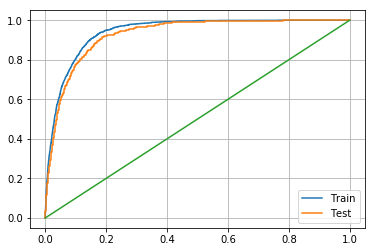

In [227]:
plot_roc_auc_curve(trainy, trainy_pred_prob,testy, testy_pred_prob)

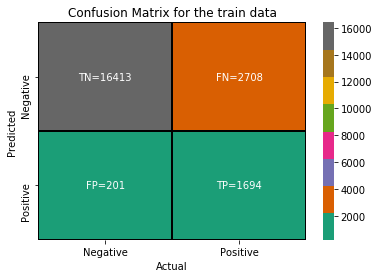

In [228]:
plot_confusion_matrix(trainy, trainy_pred, 'train')

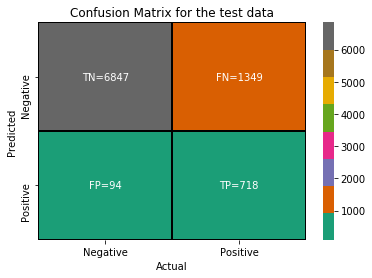

In [229]:
plot_confusion_matrix(testy, testy_pred, 'test')

**All features**

In [230]:
all_features=[]
all_features.extend(('age', 'job'))
all_features.extend(['marital_'+x for x in ohe_marital.get_feature_names()])
all_features.append(('education'))
all_features.extend(['default_'+x for x in ohe_default.get_feature_names()])
all_features.append(('balance'))
all_features.extend(['loan_'+x for x in ohe_loan.get_feature_names()])
all_features.extend(['housing_'+x for x in ohe_housing.get_feature_names()])
all_features.extend(['contact_'+x for x in ohe_contact.get_feature_names()])
all_features.extend(['month_'+x for x in ohe_month.get_feature_names()])
all_features.extend(('duration', 'campaign','pdays'))
all_features.extend(['poutcome_'+x for x in ohe_poutcome.get_feature_names()])
all_features.extend(('average_calls_current_campaign','housing_loan','housing_default','loan_default','housing_loan_default'))


# Feature Importances

In [231]:
indices = np.argsort(xgb.feature_importances_)[::-1]
importances = sorted(xgb.feature_importances_)[::-1]

from operator import itemgetter 

sorted_features = itemgetter(*indices)(all_features)

for feat, imp in zip(sorted_features, importances):
    print(feat, imp )

duration 0.11000608
contact_x0_unknown 0.107933946
housing_x0_no 0.0789597
month_x0_mar 0.05807678
housing_x0_yes 0.05798833
month_x0_jun 0.050212167
month_x0_oct 0.048230264
marital_x0_single 0.04303011
average_calls_current_campaign 0.040878527
month_x0_apr 0.040485278
month_x0_jul 0.03236382
month_x0_sep 0.029345335
month_x0_nov 0.024824908
loan_x0_no 0.023762558
poutcome_x0_unknown 0.022885894
age 0.017102215
contact_x0_cellular 0.016853556
month_x0_feb 0.01599859
month_x0_dec 0.015554714
month_x0_aug 0.015429778
pdays 0.014592684
education 0.0143718105
month_x0_may 0.014277473
month_x0_jan 0.014013025
marital_x0_married 0.012094549
balance 0.011908808
poutcome_x0_success 0.011544933
campaign 0.011375254
housing_loan 0.00988075
job 0.009684874
contact_x0_telephone 0.006644468
marital_x0_divorced 0.0061630947
poutcome_x0_other 0.0055396403
default_x0_no 0.0040597823
poutcome_x0_failure 0.0039263507
loan_x0_yes 0.0
housing_default 0.0
default_x0_yes 0.0
loan_default 0.0
housing_loan_

# storing the scaling models

In [232]:
joblib.dump(sd_age, 'sd_age.joblib')
joblib.dump(sd_balance, 'sd_balance.joblib')
joblib.dump(sd_duration, 'sd_duration.joblib')
joblib.dump(sd_campaign, 'sd_campaign.joblib')
joblib.dump(sd_pdays, 'sd_pdays.joblib')

joblib.dump(le_job, 'le_job.joblib')
joblib.dump(le_education, 'le_education.joblib')
joblib.dump(ohe_marital, 'ohe_marital.joblib')
joblib.dump(ohe_default, 'ohe_default.joblib')
joblib.dump(ohe_loan, 'ohe_loan.joblib')
joblib.dump(ohe_housing, 'ohe_housing.joblib')
joblib.dump(ohe_contact, 'ohe_contact.joblib')
joblib.dump(ohe_poutcome, 'ohe_poutcome.joblib')
joblib.dump(ohe_month, 'ohe_month.joblib')

joblib.dump(average_calls_current_campaign_sd, 'average_calls_current_campaign_sd.joblib')
joblib.dump(le_housing_loan , 'le_housing_loan.joblib')
joblib.dump(le_housing_default, 'le_housing_default.joblib')
joblib.dump(le_loan_default, 'le_loan_default.joblib')
joblib.dump(le_housing_loan_default, 'sd_campaign.joblib') 
joblib.dump(xgb, 'xgb_model.joblib') 

['xgb_model.joblib']

# Testing the model with test data point

**Load existing model**

In [237]:
sd_age = joblib.load('sd_age.joblib')
sd_balance = joblib.load('sd_balance.joblib')
sd_duration = joblib.load('sd_duration.joblib')
sd_campaign = joblib.load('sd_campaign.joblib')
sd_pdays = joblib.load('sd_pdays.joblib')

le_job = joblib.load('le_job.joblib')
le_education = joblib.load('le_education.joblib')
ohe_marital = joblib.load('ohe_marital.joblib')
ohe_default = joblib.load('ohe_default.joblib')
ohe_loan = joblib.load('ohe_loan.joblib')
ohe_housing = joblib.load('ohe_housing.joblib')
ohe_contact = joblib.load('ohe_contact.joblib')
ohe_poutcome = joblib.load('ohe_poutcome.joblib')
ohe_month = joblib.load('ohe_month.joblib')

average_calls_current_campaign_sd = joblib.load('average_calls_current_campaign_sd.joblib')
le_housing_loan = joblib.load('le_housing_loan.joblib')
le_housing_default = joblib.load('le_housing_default.joblib')
le_loan_default = joblib.load('le_loan_default.joblib')
le_housing_loan_default = joblib.load('sd_campaign.joblib') 
xgb_model = joblib.load('xgb_model.joblib') 

**Testing with sample**

In [280]:
test_samples=testx.sample(1)
test_sample

,age,job,marital,education,default,balance,housing,loan,contact,month,duration,campaign,pdays,poutcome,housing_loan,housing_default,loan_default,housing_loan_default,average_calls_current_campaign
7477,34.0,services,married,secondary,no,88.0,yes,yes,unknown,may,1.366667,2.0,-1.0,unknown,True,False,False,False,0.683333


In [281]:
testy_sample = testy.loc[test_samples.index]
testy_sample

10830    0
Name: y, dtype: int64

**convert test columns to numeric vectors and predict the probability of making the term deposit**

In [288]:

######  convert test columns to numeric vectors #######

test_sample_age_sd = sd_age.transform(test_sample['age'].values.reshape(-1,1))
test_sample_balance_sd = sd_balance.transform(test_sample['balance'].values.reshape(-1,1))
test_sample_duration_sd = sd_duration.transform(test_sample['duration'].values.reshape(-1,1))
test_sample_campaign_sd = sd_campaign.transform(test_sample['campaign'].values.reshape(-1,1))
test_sample_pdays_sd = sd_pdays.transform(test_sample['pdays'].values.reshape(-1,1))  # wherever negative replace with -1

test_sample_pdays_sd = np.where(test_sample_pdays_sd<0,-1,test_sample_pdays_sd)

test_sample_job_le = le_job.transform(test_sample['job']).reshape(-1,1)
test_sample_education_le = le_education.transform(test_sample['education']).reshape(-1,1)
test_sample_marital_ohe = ohe_marital.transform(test_sample['marital'].values.reshape(-1,1))
test_sample_default_ohe = ohe_default.transform(test_sample['default'].values.reshape(-1,1))
test_sample_housing_ohe = ohe_housing.transform(test_sample['housing'].values.reshape(-1,1))
test_sample_loan_ohe = ohe_loan.transform(test_sample['loan'].values.reshape(-1,1))
test_sample_contact_ohe = ohe_contact.transform(test_sample['contact'].values.reshape(-1,1))
test_sample_month_ohe = ohe_month.transform(test_sample['month'].values.reshape(-1,1))
test_sample_poutcome_ohe = ohe_poutcome.transform(test_sample['poutcome'].values.reshape(-1,1))

test_sample_housing_loan_le = le_housing_loan.transform(test_sample['housing_loan']).reshape(-1,1)
test_sample_housing_default_le = le_housing_default.transform(test_sample['housing_default']).reshape(-1,1)
test_sample_loan_default_le = le_loan_default.transform(test_sample['loan_default']).reshape(-1,1)
test_sample_housing_loan_default_le = le_housing_loan_default.transform(test_sample['housing_loan_default']).reshape(-1,1)
test_sample_average_calls_current_campaign_sd = average_calls_current_campaign_sd.transform(test_sample['average_calls_current_campaign'].values.reshape(-1,1))

#### JOIN all the variables ####

test_sample_all = hstack((test_sample_age_sd, test_sample_job_le, test_sample_marital_ohe, test_sample_education_le, test_sample_default_ohe, test_sample_balance_sd, test_sample_loan_ohe, test_sample_housing_ohe, test_sample_contact_ohe, test_sample_month_ohe, test_sample_duration_sd, test_sample_campaign_sd, test_sample_pdays_sd, test_sample_poutcome_ohe, test_sample_average_calls_current_campaign_sd, test_sample_housing_loan_le,test_sample_housing_default_le, test_sample_loan_default_le, test_sample_housing_loan_default_le))


##### Predict the probability ######

print('Probability of making term deposit', xgb_model.predict_proba(test_sample_all)[:,1][0])

#####Predict whether the customer will make term deposit or not#######

result = {1:'Yes', 0:'No'}

print('whether customer will make term deposit', result[xgb_model.predict(test_sample_all)[0]])


Probability of making term deposit 0.00797432
whether customer will make term deposit No


c:\users\rap\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


# Model comparison

In [289]:
from prettytable import PrettyTable

In [303]:
table = PrettyTable()
table.field_names = ['Model','Train roc', 'Test_roc']
table.add_row(['KNN', 1.0, 0.674])
table.add_row(['LR', 0.725, 0.731])
table.add_row(['RBF SVM',0.753,0.725])
table.add_row(['Linear SVM',0.711,0.713])
table.add_row(['XGBoost',0.755,0.733])
table.add_row(['Feature engineered',0.942,0.927])
print(table)

+--------------------+-----------+----------+
|       Model        | Train roc | Test_roc |
+--------------------+-----------+----------+
|        KNN         |    1.0    |  0.674   |
|         LR         |   0.725   |  0.731   |
|      RBF SVM       |   0.753   |  0.725   |
|     Linear SVM     |   0.711   |  0.713   |
|      XGBoost       |   0.755   |  0.733   |
| Feature engineered |   0.942   |  0.927   |
+--------------------+-----------+----------+


# Conclusions

- Major disbalance in the data.
- Marital status wise data distribution for term depositors vs non depositors.
- Term depositors contribution marital status wise.
- Out of people making term deposit single and married are the major contributors.
- Majority of term depositors are from early 30+ ages.
- for both term depositors vs non depositor we have 0 balances.
- Term desposits are mostly from people who dont have any loan or housing.
- Most busy months are April, May, June, July and August.
- Term depositor calls are longer than non term depositors.
- Mostly pdays are -1 which means customers were not called, however to save some data we have considered pdays<=60.
- Management and retired class of people tend to have higher balances may be due to higher salary or post retirement savings.
- people with tertiary class of education, seems that have more balance -- may be due to higher income. Also more people are there with secondary and primary education due to large bandwidth that the graphs are showing.
- Average balance of retired and management customers who opted for term deposit are on the higher side even after having some or other liabilties.
- Term depositors tend to maintain Higher balance.
- Call duration for term depositor is higher usually.
- Y is strongly postively related with duration of the call made to attract customers.
- We have tried many models here and Xgboost has perfomed well with 0.92 roc auc score however FN is generally high for all of them which is not good (meaning that large numbers of prospect customers are predicted to be non prospect).
- I feel that getting more data from depositor section can bring some good results since high disbalance in the data. 

# Advice to Bank from  data analyst

Based on the data set present here
- Please try to get more data if possible. 
- To attract more number of customers, Bank should make more calls to customers since data above says majority of the customers were never called whereas large call durations is the determining factor here in predicting whether customers will make term deposit. 